# Using `scipy.integrate`

## Authors
Zach Pace, Lia Corrales, Stephanie T. Douglas

## Learning Goals
* perform numerical integration in the `astropy` and scientific python context
 * trapezoidal approximation
 * gaussian quadrature
* use `astropy`'s built-in black-body curves
* understand how `astropy`'s units interact with one another
* define a Python class
 * how the `__call__` method works
* add $\LaTeX$ labels to `matplotlib` figures using the `latex_inline` formatter

## Keywords
modeling, units, synphot, OOP, LaTeX, astrostatistics, matplotlib, units, physics

## Companion Content
* http://synphot.readthedocs.io/en/latest/
* [Using Astropy Quantities for astrophysical calculations](https://learn.astropy.org/tutorials/quantities.html)

## Summary
In this tutorial, we will use the examples of the Planck function and the stellar initial mass function (IMF) to illustrate how to integrate numerically, using the trapezoidal approximation and Gaussian quadrature. We will also explore making a custom class, an instance of which is callable in the same way as a function. In addition, we will encounter `astropy`'s built-in units, and get a first taste of how to convert between them. Finally, we will use $\LaTeX$ to make our figure axis labels easy to read.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
matplotlib
numpy
scipy



In [2]:
import numpy as np
from scipy import integrate
from astropy.modeling.models import BlackBody
from astropy import units as u, constants as c
import matplotlib.pyplot as plt

%matplotlib inline

## The Planck function

The Planck function describes how a black-body radiates energy. We will explore how to find bolometric luminosity using the Planck function in both frequency and wavelength space.

Let's say we have a black-body at 5000 Kelvin. We can find out the total intensity (bolometric) from this object, by integrating the Planck function. The simplest way to do this is by approximating the integral using the trapezoid rule. Let's do this first using the frequency definition of the Planck function.

We'll define a photon frequency grid, and evaluate the Planck function at those frequencies. Those will be used to numerically integrate using the trapezoidal rule. By multiplying a `numpy` array by an `astropy` unit, we get a `Quantity`, which is effectively a combination of one or more numbers and a unit.

<div class="alert alert-info">
**Note on printing units**: 

Quantities and units can be printed to strings using the [Format String Syntax](https://docs.python.org/3/library/string.html#format-string-syntax). This demonstration uses the `latex_inline` format that is built in to the `astropy.units` package. To see additional ways to format quantities, see the [Getting Started](http://docs.astropy.org/en/stable/units/#getting-started) section of the astropy.units documentation pages.
</div>

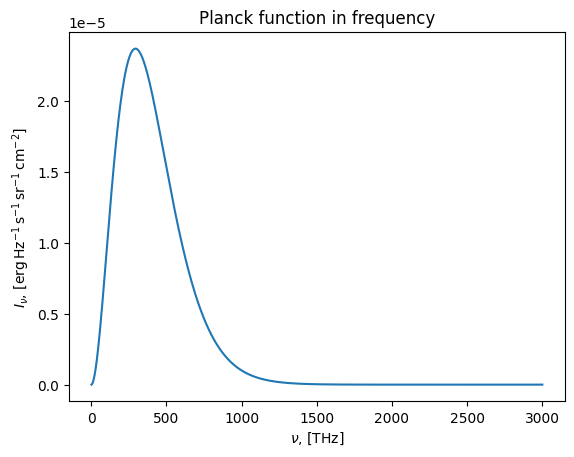

In [3]:
bb = BlackBody(5000. * u.Kelvin)

nu = np.linspace(1., 3000., 1000) * u.THz
bb5000K_nu = bb(nu)
plt.plot(nu, bb5000K_nu)
plt.xlabel(r'$\nu$, [{0:latex_inline}]'.format(nu.unit))
plt.ylabel(r'$I_{\nu}$, ' + '[{0:latex_inline}]'.format(bb5000K_nu.unit))
plt.title('Planck function in frequency')
plt.show()

### Using $LaTeX$ for axis labels

Here, we've used $LaTeX$ markup to add nice-looking axis labels. To do that, we enclose $LaTeX$ markup text in dollar signs, within a string `r'\$ ... \$'`. The `r` before the open-quote denotes that the string is "raw," and backslashes are treated literally. This is the suggested format for axis label text that includes markup.

Now we numerically integrate using the trapezoid rule.

In [4]:
np.trapz(x=nu, y=bb5000K_nu).to('erg s-1 cm-2 sr-1')

/tmp/ipykernel_4326/3733651102.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(x=nu, y=bb5000K_nu).to('erg s-1 cm-2 sr-1')


<Quantity 1.12808487e+10 erg / (s sr cm2)>

Now we can do something similar, but for a wavelength grid. We want to integrate over an equivalent wavelength range to the frequency range we did earlier. We can transform the maximum frequency into the corresponding (minimum) wavelength by using the `.to()` method, with the addition of an *equivalency*.

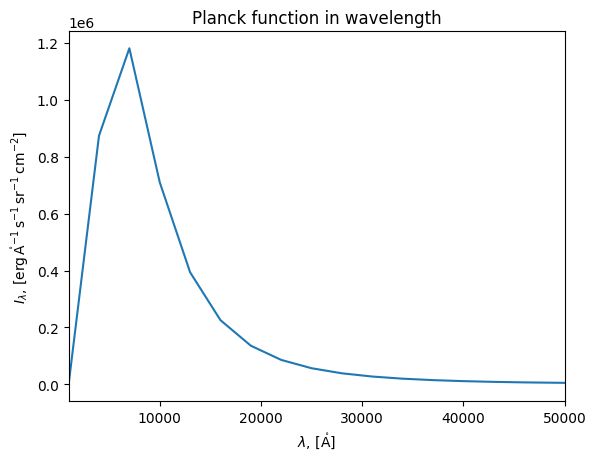

In [5]:
lam = np.linspace(nu.max().to(u.AA, equivalencies=u.spectral()),
                  nu.min().to(u.AA, equivalencies=u.spectral()), 1000)
bb_lam = BlackBody(bb.temperature, 
                   scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
bb5000K_lam = bb_lam(lam)
plt.plot(lam, bb5000K_lam)
plt.xlim([1.0e3, 5.0e4])
plt.xlabel(r'$\lambda$, [{0:latex_inline}]'.format(lam.unit))
plt.ylabel(r'$I_{\lambda}$, ' + '[{0:latex_inline}]'.format(bb5000K_lam.unit))
plt.title('Planck function in wavelength')
plt.show()

In [6]:
np.trapz(x=lam, y=bb5000K_lam).to('erg s-1 cm-2 sr-1')

/tmp/ipykernel_4326/808934492.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(x=lam, y=bb5000K_lam).to('erg s-1 cm-2 sr-1')


<Quantity 1.14677601e+10 erg / (s sr cm2)>

Notice this is within a couple percent of the answer we got in frequency space, despite our bad sampling at small wavelengths!

Many `astropy` functions use units and quantities directly. As you gain confidence working with them, consider incorporating them into your regular workflow. Read more [here](http://docs.astropy.org/en/stable/units/) about how to use units.

### How to simulate actual observations

As of Fall 2017, `astropy` does not explicitly support constructing synthetic observations of models like black-body curves. The [synphot library](https://synphot.readthedocs.io/en/latest/) does allow this. You can use `synphot` to perform tasks like turning spectra into visual magnitudes by convolving with a filter curve.

## The stellar initial mass function (IMF)

The stellar initial mass function tells us how many of each mass of stars are formed. In particular, low-mass stars are much more abundant than high-mass stars are. Let's explore more of the functionality of `astropy` using this concept.

People generally think of the IMF as a power-law probability density function. In other words, if you count the stars that have been born recently from a cloud of gas, their distribution of masses will follow the IMF. Let's write a little class to help us keep track of that:

In [7]:
class PowerLawPDF(object):
    def __init__(self, gamma, B=1.):
        self.gamma = gamma
        self.B = B
    def __call__(self, x):
        return x**self.gamma / self.B

### The `__call__` method

By defining the method `__call__`, we are telling the Python interpreter that an instance of the class can be called like a function. When called, an instance of this class, takes a single argument, `x`, but it uses other attributes of the instance, like `gamma` and `B`.

### More about classes

Classes are more advanced data structures, which can help you keep track of functionality within your code that all works together. You can learn more about classes in [this tutorial](https://www.codecademy.com/ja/courses/learn-python/lessons/introduction-to-classes/exercises/why-use-classes).

## Integrating using Gaussian quadrature

In this section, we'll explore a method of numerical integration that does not require having your sampling grid set-up already. `scipy.integrate.quad` with reference [here](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.integrate.quad.html) takes a function and both a lower and upper bound, and our `PowerLawPDF` class takes care of this just fine.

Now we can use our new class to normalize our IMF given the mass bounds. This amounts to normalizing a probability density function. We'll use Gaussian quadrature (`quad`) to find the integral. `quad` returns the numerical value of the integral and its uncertainty. We only care about the numerical value, so we'll pack the uncertainty into `_` (a placeholder variable). We immediately throw the integral into our IMF object and use it for normalizing!

To read more about *generalized packing and unpacking* in Python, look at the original proposal, [PEP 448](https://www.python.org/dev/peps/pep-0448/), which was accepted in 2015.

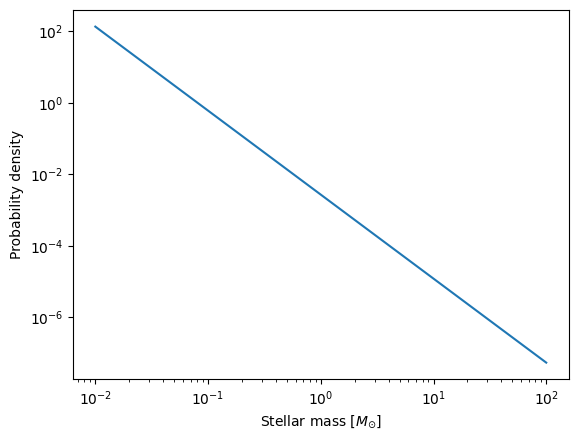

In [8]:
salpeter = PowerLawPDF(gamma=-2.35)
salpeter.B, _ = integrate.quad(salpeter, a=0.01, b=100.)

m_grid = np.logspace(-2., 2., 100)
plt.loglog(m_grid, salpeter(m_grid))
plt.xlabel(r'Stellar mass [$M_{\odot}$]')
plt.ylabel('Probability density')
plt.show()

### How many more M stars are there than O stars?

Let's compare the number of M dwarf stars (mass less than 60% solar) created by the IMF, to the number of O stars (mass more than 15 times solar).

In [9]:
n_m, _ = integrate.quad(salpeter, a=.01, b=.6)
n_o, _ = integrate.quad(salpeter, a=15., b=100.)
print(n_m / n_o)

20936.017868337385


There are almost 21000 as many low-mass stars born as there are high-mass stars!

### Where is all the mass?

Now let's compute the relative total masses for all O stars and all M stars born. To do this, weight the Salpeter IMF by mass (i.e., add an extra factor of mass to the integral). To do this, we define a new function that takes the old power-law IMF as one of its arguments. Since this argument is unchanged throughout the integral, it is passed into the tuple `args` within `quad`. It's important that there is only *one* argument that changes over the integral, and that it is the *first* argument that the function being integrated accepts.

Mathematically, the integral for the M stars is

$$ m^M = \int_{.01 \, M_{\odot}}^{.6 \, M_{\odot}} m \, {\rm IMF}(m) \, dm $$

and it amounts to weighting the probability density function (the IMF) by mass. More generally, you find the value of some property $\rho$ that depends on $m$ by calculating

$$ \rho(m)^M = \int_{.01 \, M_{\odot}}^{.6 \, M_{\odot}} \rho(m) \, {\rm IMF}(m) \, dm $$

In [10]:
def IMF_m(m, imf):
    return imf(m) * m

m_m, _ = integrate.quad(IMF_m, a=.01, b=.6, args=(salpeter, ))
m_o, _ = integrate.quad(IMF_m, a=15., b=100., args=(salpeter, ))

m_m / m_o

20.29197629920483

So about 20 times as much mass is tied up in M stars as in O stars.

### Extras

* Now compare the total luminosity from all O stars to total luminosity from all M stars. This requires a mass-luminosity relation, like this one which you will use as $\rho(m)$:

$$
 \frac{L}{L_{\odot}} (M) =
  \begin{cases} 
      \hfill .23 \left( \frac{M}{M_{\odot}} \right)^{2.3} \hfill , \hfill & .1 < \frac{M}{M_{\odot}} < .43 \\
      \hfill \left( \frac{M}{M_{\odot}} \right)^{4} \hfill , \hfill & .43 < \frac{M}{M_{\odot}} < 2 \\
      \hfill 1.5 \left( \frac{M}{M_{\odot}} \right)^{3.5} \hfill , \hfill & 2 < \frac{M}{M_{\odot}} < 20 \\
      \hfill 3200 \left( \frac{M}{M_{\odot}} \right) \hfill , \hfill & 20 < \frac{M}{M_{\odot}} < 100 \\
  \end{cases},
$$

* Think about which stars are producing most of the light, and which stars have most of the mass. How might this result in difficulty inferring stellar masses from the light they produce? If you're interested in learning more, see [this review article](https://ned.ipac.caltech.edu/level5/Sept14/Courteau/Courteau_contents.html).

## Challenge problems

* Right now, we aren't worried about the bounds of the power law, but the IMF should drop off to zero probability at masses below .01 solar masses and above 100 solar masses. Modify `PowerLawPDF` in a way that allows both `float` and `numpy.ndarray` inputs.
* Modify the `PowerLawPDF` class to explicitly use `astropy`'s `units` constructs.
* Derive a relationship between recent star-formation rate and $H\alpha$ luminosity. In other words, find a value of $C$ for the function

$${\rm SFR \, [\frac{M_{\odot}}{yr}]} = {\rm C \, L_{H\alpha} \, [\frac{erg}{s}]} \, .$$

* How does this depend on the slope and endpoints of the IMF?
* Take a look at Appendix B of [Hunter & Elmegreen 2004, AJ, 128, 2170](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/0408229)
* What effect does changing the power-law index or upper mass limit of the IMF have on the value of $C$?
* Predict the effect on the value of $C$ of using a different form of the IMF, like Kroupa or Chabrier (both are lighter on the low-mass end).
* If you're not tired of IMFs yet, try defining a new class that implements a broken-power-law (Kroupa) or log-parabola (Chabrier) IMF. Perform the same calculations as above.